# Final catboost predictions with new features

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

## Load and merge data

In [2]:
active_cells = (1076, 1126, 1127, 1128, 1129, 1132, 1180, 1181, 1230, 1231, 1232, 1233, 1234, 1282,
 1283, 1339, 1383, 1431, 1684, 1734, 2069, 2119, 1075, 1125, 1221, 1227, 1272, 1326, 1331, 1382, 1434, 1441, 1480, 1482, 1483, 1530,
 1532, 1533, 1580, 1630, 1733, 1783, 2068, 2118, 2168, 1173, 1174, 1175, 1176, 1183, 1225, 1278, 1388, 1389, 1390, 1436, 1437, 1438, 1439,
 1442, 1130, 1131, 1172, 1177, 1178, 1179, 1222, 1223, 1224, 1228, 1229, 1273, 1274, 1279,
 1327, 1376, 1377, 1378, 1380, 1426, 1077, 1182, 1184, 1235, 1280, 1281, 1284, 1285, 1286, 1287, 1332, 1333, 1334, 1335,
 1336, 1337, 1338, 1384, 1385, 1386, 1387, 1435)

In [72]:
cluster_1 = (1076, 1126, 1127, 1128, 1129, 1132, 1180, 1181, 1230, 1231, 1232, 1233, 1234, 1282,
 1283, 1339, 1383, 1431, 1684, 1734, 2069, 2119)
cluster_2 = (1075, 1125, 1221, 1227, 1272, 1326, 1331, 1382, 1434, 1441, 1480, 1482, 1483, 1530,
 1532, 1533, 1580, 1630, 1733, 1783, 2068, 2118, 2168)
cluster_3 = (1173, 1174, 1175, 1176, 1183, 1225, 1278, 1388, 1389, 1390, 1436, 1437, 1438, 1439,
 1442)
cluster_4 = (1130, 1131, 1172, 1177, 1178, 1179, 1222, 1223, 1224, 1228, 1229, 1273, 1274, 1279,
 1327, 1376, 1377, 1378, 1380, 1426)
cluster_5 = (1077, 1182, 1184, 1235, 1280, 1281, 1284, 1285, 1286, 1287, 1332, 1333, 1334, 1335,
 1336, 1337, 1338, 1384, 1385, 1386, 1387, 1435)

def find_cluster(region):
    if region in cluster_1:
        return 1
    if region in cluster_2:
        return 2
    if region in cluster_3:
        return 3
    if region in cluster_4:
        return 4
    if region in cluster_5:
        return 5

In [4]:
def format_and_merge_data(data_name):
    # function takes name of data file and returns one full data frame of that files with date_range indexing
    data_list = []
    for i in range(1,7):
        data = pd.read_csv('{}_{}.csv'.format(data_name, i))
        data = data[data['region'].isin(active_cells)]
        data = data.T
        data.columns = data.iloc[0].astype('int')
        data.drop('region', axis=0, inplace=True)
        data_list.append(data)
    final_data = pd.concat(data_list)
    final_data.set_index(pd.date_range('01/01/2016', periods=int(final_data.shape[0]), freq='H'), inplace=True)
    return final_data

In [5]:
trips_by_regions_neighbours = format_and_merge_data('trips_by_regions_neighbours')
trips_in_region = format_and_merge_data('trips_in_region')
trips_to_region = format_and_merge_data('trips_to_region')

## feature engineering

In [85]:
def make_regressive_features(series):
    
    # function takes a series of values and returns a dataframe of features for a regressor
    
    isWeekend = lambda x: 1 if x in (5, 6) else 0
    def isHoliday(x):
        if ((x[0]==1 and x[1]==1) or (x[0]==18 and x[1]==1) or (x[0]==15 and x[1]==2) or (x[0]==15 and x[1]==4) or (x[0]==8 and x[1]==5) or (x[0]==30 and x[1]==5) or (x[0]==19 and x[1]==6)):
            return 1
        else:
            return 0
        
    feature_df = pd.DataFrame()
    
    
    feature_df['is_weekend'] = [isWeekend(i) for i in series.index.dayofweek]
    feature_df['is_holiday'] = [isHoliday(x) for x in zip(series.index.day, series.index.month)]

    feature_df['hour_cat'] = series.index.hour
    feature_df['day_cat'] = series.index.dayofweek
    feature_df['month_cat'] = series.index.month


    for i in range(24):
        feature_df['sin_value_month_{}'.format(i)] = np.sin(np.arange(series.shape[0]) * 2*np.pi * i/720)
        feature_df['cos_value_month_{}'.format(i)] = np.cos(np.arange(series.shape[0]) * 2*np.pi * i/720)
    for i in range(24):
        feature_df['sin_value_week_{}'.format(i)] = np.sin(np.arange(series.shape[0]) * 2*np.pi * i/168)
        feature_df['cos_value_week_{}'.format(i)] = np.cos(np.arange(series.shape[0]) * 2*np.pi * i/168)
    for i in range(24):
        feature_df['sin_value_day_{}'.format(i)] = np.sin(np.arange(series.shape[0]) * 2*np.pi * i/24)
        feature_df['cos_value_day_{}'.format(i)] = np.cos(np.arange(series.shape[0]) * 2*np.pi * i/24)
        
    values = (2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 24, 48, 96, 168, 720)
    
    for i in values:
        feature_df['mean_{}'.format(i)] = series.reset_index()[0].rolling(i).mean()
        feature_df['sum_{}'.format(i)] = series.reset_index()[0].rolling(i).sum()

    feature_df['hour'] = series.index.hour
    feature_df['day'] = series.index.dayofweek
    feature_df['month'] = series.index.month

    for i in range(16):
        feature_df['prev_{}'.format(i)] = series.reset_index()[0].shift(i)
    for i in range(24, 169, 24):
        feature_df['prev_{}'.format(i)] = series.reset_index()[0].shift(i)
    for i in range(168, 2353, 168):
        feature_df['prev_{}'.format(i)] = series.reset_index()[0].shift(i)
        
    feature_df.set_index(series.index, inplace=True)

    return feature_df.fillna(-999999)

def make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, hour_in_future, time):
    # trips_in_region, trips_to_region, trips_by_regions_neighbours - formatted dataframes with time indexis
    # hour_in_future - amounth of hours in the future to predict (from 1 to 6)
    
    X = pd.DataFrame()
    
    ys = []
    trips_to_region_list = []
    trips_in_region_list = []
    trips_by_regions_neighbours_list = []
    region_list = []
    series = pd.Series()

    for i in trips_in_region:
        ys.append(trips_in_region[i][:time].shift(-hour_in_future))
        trips_to_region_list.append(trips_to_region[i][:time])
        trips_by_regions_neighbours_list.append(trips_by_regions_neighbours[i][:time])
        trips_in_region_list.append(trips_in_region[i][:time])
        region_list += [i] * trips_in_region[:time].shape[0]

        
    X['y'] = pd.concat(ys)
    X['trips_to_region'] = pd.concat(trips_to_region_list)
    X['trips_by_regions_neighbours'] = pd.concat(trips_by_regions_neighbours_list)
    X['region'] = region_list
    X['cluster'] = [find_cluster(i) for i in region_list]
    series = pd.concat(trips_in_region_list)
    df_features = make_regressive_features(series)
    X = pd.concat([X, df_features], axis=1)
    return X.dropna()

In [ ]:
data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 1, pd.to_datetime('05/01/2016 00:00:00'))
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], 
                                                    test_size=0.3, shuffle=True, random_state=42)

In [88]:
cat_features = [2, 3, 4, 5, 6, 7, 8]

## Fitting

In [89]:
%%time

n_iters = 1000
time = pd.to_datetime('04/30/2016 23:00:00')

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 1, time)
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.25, random_state=42)
cat1 = CatBoostRegressor(iterations=n_iters)
cat1.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(1, MAE(cat1.predict(X_test,), y_test)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 2, time)
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.25, random_state=42)
cat2 = CatBoostRegressor(iterations=n_iters)
cat2.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(2, MAE(cat2.predict(X_test,), y_test)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 3, time)
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.25, random_state=42)
cat3 = CatBoostRegressor(iterations=n_iters)
cat3.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(3, MAE(cat3.predict(X_test,), y_test)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 4, time)
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.25, random_state=42)
cat4 = CatBoostRegressor(iterations=n_iters)
cat4.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(4, MAE(cat4.predict(X_test,), y_test)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 5, time)
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.25, random_state=42)
cat5 = CatBoostRegressor(iterations=n_iters)
cat5.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(5, MAE(cat5.predict(X_test,), y_test)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 6, time)
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.25, random_state=42)
cat6 = CatBoostRegressor(iterations=n_iters)
cat6.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(6, MAE(cat6.predict(X_test,), y_test)))


prediction on 1 hour MAE: 17.56587434300029
prediction on 2 hour MAE: 21.785222612068864
prediction on 3 hour MAE: 23.752520617548377
prediction on 4 hour MAE: 24.55193816553756
prediction on 5 hour MAE: 25.56205371155058
prediction on 6 hour MAE: 25.321562734529326
Wall time: 35min 28s


## Predict on May

In [122]:
data_for_predictions = make_train_data(trips_in_region, trips_to_region,
                                       trips_by_regions_neighbours, 1, 
                                       pd.to_datetime('06/30/2016 23:00:00')).drop('y', axis=1)

time_range_may = pd.date_range('05/01/2016 00:00:00', periods=31*24-6, freq='H')

## Mean absolute error on May

In [126]:
predictions = []
real_values = []
for region in active_cells:
    for time in time_range_may:
        data_to_predict = pd.DataFrame(data_for_predictions[data_for_predictions['region']==region].loc[time]).T
        for i in range(1,7):
            real_values.append(trips_in_region[region].loc[time + i])
        predictions.append(cat1.predict(data_to_predict)[0])
        predictions.append(cat2.predict(data_to_predict)[0])
        predictions.append(cat3.predict(data_to_predict)[0])
        predictions.append(cat4.predict(data_to_predict)[0])
        predictions.append(cat5.predict(data_to_predict)[0])
        predictions.append(cat6.predict(data_to_predict)[0])

In [125]:
print('Q = {}'.format(MAE(predictions, real_values)))

Q = 24.397375777809856


## June predictions

### fitting on all the data untill June

In [159]:
%%time

n_iters = 4000
time = pd.to_datetime('05/31/2016 23:00:00')

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 1, time)
X, y = data.drop('y', axis=1), data['y']
cat1 = CatBoostRegressor(iterations=n_iters)
cat1.fit(X, y, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(1, MAE(cat1.predict(X), y)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 2, time)
X, y = data.drop('y', axis=1), data['y']
cat2 = CatBoostRegressor(iterations=n_iters)
cat2.fit(X, y, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(2, MAE(cat2.predict(X), y)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 3, time)
X, y = data.drop('y', axis=1), data['y']
cat3 = CatBoostRegressor(iterations=n_iters)
cat3.fit(X, y, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(3, MAE(cat3.predict(X), y)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 4, time)
X, y = data.drop('y', axis=1), data['y']
cat4 = CatBoostRegressor(iterations=n_iters)
cat4.fit(X, y, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(4, MAE(cat4.predict(X), y)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 5, time)
X, y = data.drop('y', axis=1), data['y']
cat5 = CatBoostRegressor(iterations=n_iters)
cat5.fit(X, y, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(5, MAE(cat5.predict(X), y)))

data = make_train_data(trips_in_region, trips_to_region, trips_by_regions_neighbours, 6, time)
X, y = data.drop('y', axis=1), data['y']
cat6 = CatBoostRegressor(iterations=n_iters)
cat6.fit(X, y, cat_features=cat_features, silent=True)
print('prediction on {} hour MAE: {}'.format(6, MAE(cat6.predict(X), y)))

prediction on 1 hour MAE: 14.777137312962692
prediction on 2 hour MAE: 17.226430893009695
prediction on 3 hour MAE: 18.10609282176826
prediction on 4 hour MAE: 18.476919211104367
prediction on 5 hour MAE: 18.876197261852454
prediction on 6 hour MAE: 18.984902355928117
Wall time: 4h 29min 33s


## Predicting on June data

In [153]:
data_for_predictions = make_train_data(trips_in_region, trips_to_region,
                                       trips_by_regions_neighbours, 1, 
                                       pd.to_datetime('06/30/2016 23:00:00')).drop('y', axis=1)

time_range_may = pd.date_range('05/31/2016 23:00:00', periods=30*24-5, freq='H')

In [160]:
%%time
result = []
for region in active_cells:
    for time in time_range_may:
        data_to_predict = pd.DataFrame(data_for_predictions[data_for_predictions['region']==region].loc[time]).T
        predictions = []
        predictions.append(cat1.predict(data_to_predict)[0])
        predictions.append(cat2.predict(data_to_predict)[0])
        predictions.append(cat3.predict(data_to_predict)[0])
        predictions.append(cat4.predict(data_to_predict)[0])
        predictions.append(cat5.predict(data_to_predict)[0])
        predictions.append(cat6.predict(data_to_predict)[0])
        for i in range(6):
            result.append({'id' : '{}_{}-{}-{}_{}_{}'.format(region, time.year, time.month, time.day, time.hour, i+1),
                               'y' : predictions[i]})
result = pd.DataFrame(result)

Wall time: 16min 31s


## formatting final data ids  

In [161]:
new_ids = []
for i in result['id'].values:
    if i[10]=='5':
        new_ids.append(i.replace('-5-', '-05-'))
    else:
        new_ids.append(i.replace('-6-', '-06-'))
result['id'] = new_ids


new_ids = []
v = ['-1_', '-2_', '-3_', '-4_', '-5_', '-6_', '-7_', '-8_', '-9_']
v_ = ['-01_', '-02_', '-03_', '-04_', '-05_', '-06_', '-07_', '-08_', '-09_']
for i in result['id'].values:
    target = i[12:15]
    if target in v:
        new_ids.append(i.replace(target, v_[v.index(target)]))
    else:
        new_ids.append(i)
result['id'] = new_ids

In [162]:
result.shape

(437580, 2)

In [163]:
result.head()

,id,y
0,1076_2016-05-31_23_1,41.721044
1,1076_2016-05-31_23_2,19.597862
2,1076_2016-05-31_23_3,10.728752
3,1076_2016-05-31_23_4,0.811198
4,1076_2016-05-31_23_5,8.030252


In [164]:
result.to_csv('results_cat_full_4.csv', index=False)

## Kaggle results

<img src="kaggle.PNG">

## Feature importance

Let's look on feature importance list for 1 hour predictions

In [244]:
import operator

feature_imp_dict = {}
for i,j in zip(data_for_predictions, cat1.get_feature_importance()):
    feature_imp_dict[i] = j
feature_imp_dict = pd.DataFrame(sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True), columns=('Feature', 'Importance value'))



In [246]:
feature_imp_dict.head(10)

,Feature,Importance value
0,prev_0,59.476272
1,trips_to_region,5.108621
2,prev_15,2.514897
3,cos_value_week_7,2.476856
4,mean_168,1.849821
5,prev_24,1.686047
6,sin_value_day_1,1.296508
7,cos_value_day_23,1.101141
8,sin_value_week_7,1.038972
9,hour,1.011116


## plot for 2 weeks predictions for a random cell

In [281]:
cat1_predictions = cat1.predict(data_for_predictions[data_for_predictions['region']==1337].loc['2016-05-31 23:00:00': '2016-06-13 23:00:00'])

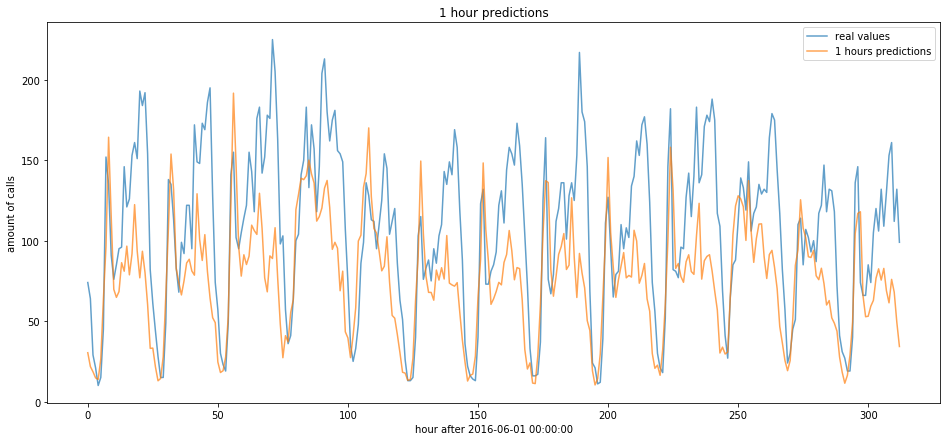

In [288]:
plt.figure(figsize=(16, 7))
plt.plot(trips_to_region[1337]['2016-06-01 00:00:00': '2016-06-14 00:00:00'].values, label='real values', alpha=0.7)

plt.plot(cat1_predictions, alpha=0.7, label='1 hours predictions')
plt.ylabel('amount of calls')
plt.xlabel('hour after 2016-06-01 00:00:00')
plt.title('1 hour predictions')
plt.legend();